In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline


Grab some std1 files

In [2]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/'
files = [f.split('.')[0] for f in os.listdir(prefix) if f.endswith('.csv') and 'Std_1' in f]
print files

['batch1_Std_1_1', 'batch1_Std_1_2', 'batch2_Std_1_1', 'batch2_Std_1_2', 'batch3_Std_1_1', 'batch3_Std_1_2', 'batch4_Std_1_1', 'batch4_Std_1_2']


In [3]:
filename = files[0]
bl = BetaLike()
print "Running file " + filename
csvfile = prefix + filename + '.csv'
matfile = prefix + filename + '.corr.mat'
signalfile = prefix + filename + '.peakml.signal'
coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.9,correct=True)

Running file batch1_Std_1_1
1357.622802
Loaded 6150 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 3186 clusters


In [49]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/pos_transformations_reduced.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 54 transformations


In [50]:
for t in transformations:
    print t,t.vote

M+ACN+H 0.4
M+ACN+H[C13] 0.36
M+ACN+H[2C13] 0.36
[M-H2O]+ACN+H 0.2
[M-H2O]+ACN+H[C13] 0.18
[M-H2O]+ACN+H[2C13] 0.18
[M-CO]+ACN+H 0.2
[M-CO]+ACN+H[C13] 0.18
[M-CO]+ACN+H[2C13] 0.18
2M+H 0.4
2M+H[C13] 0.36
2M+H[2C13] 0.36
[2M-H2O]+H 0.2
[2M-H2O]+H[C13] 0.18
[2M-H2O]+H[2C13] 0.18
[2M-CO]+H 0.2
[2M-CO]+H[C13] 0.18
[2M-CO]+H[2C13] 0.18
M+Na 0.6
M+Na[C13] 0.54
M+Na[2C13] 0.54
[M-H2O]+Na 0.3
[M-H2O]+Na[C13] 0.27
[M-H2O]+Na[2C13] 0.27
[M-CO]+Na 0.3
[M-CO]+Na[C13] 0.27
[M-CO]+Na[2C13] 0.27
M+K 0.6
M+K[C13] 0.54
M+K[2C13] 0.54
[M-H2O]+K 0.3
[M-H2O]+K[C13] 0.27
[M-H2O]+K[2C13] 0.27
[M-CO]+K 0.3
[M-CO]+K[C13] 0.27
[M-CO]+K[2C13] 0.27
M+2H 0.4
M+2H[C13] 0.36
M+2H[2C13] 0.36
[M-H2O]+2H 0.2
[M-H2O]+2H[C13] 0.18
[M-H2O]+2H[2C13] 0.18
[M-CO]+2H 0.2
[M-CO]+2H[C13] 0.18
[M-CO]+2H[2C13] 0.18
M+H 1.0
M+H[C13] 0.9
M+H[2C13] 0.9
[M-H2O]+H 0.5
[M-H2O]+H[C13] 0.45
[M-H2O]+H[2C13] 0.45
[M-CO]+H 0.5
[M-CO]+H[C13] 0.45
[M-CO]+H[2C13] 0.45


Transform a cluster and see what we get

In [57]:
def print_cluster(cluster):
    plt.figure()
    for peak in cluster.members:
        plt.plot([peak.mass,peak.mass],[0,peak.intensity],'r')

Bin the masses into nominal (integer bins)

In [152]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)
    def __repr__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)

Load the standards database from file

In [153]:
std_file = base_dir + 'dbs/std1_20130822_130526.csv'
mols = []
with open(std_file,'rU') as f:
    for i in range(9):
        f.readline() # remove heads
    for line in f:
        split_line = line.split(',')
        polarity = split_line[4]
        rt = float(split_line[8])
        if polarity == '+' and rt > 0.0:
            name = split_line[2]
            formula = split_line[3]
            rt = float(split_line[8])
            f = Formula(formula)
            new_mol = Mol(name,formula,f.compute_exact_mass(),rt*60.0)
            mols.append(new_mol)
mols = sorted(mols,key = lambda x: x.mass)

Find the protonated transformation for baselining

In [60]:
protonated = [t for t in transformations if t.name=='M+H'][0]

Functions for matching peaks to a database

In [61]:
def hit(m1,m2,rt1,rt2,mtol=20,rttol=1):
    if 1e6*np.abs(m1-m2)/m2 < mtol and np.abs(rt1-rt2)<rttol:
        return True
    else:
        return False
    
def get_hits(peaks,mols,transformations,mtol=20,rttol = 120.0):
    hits = {}
    for mol in mols:
        for peak in peaks:
            for t in transformations:
                if hit(t.transform(peak),mol.mass,peak.rt,mol.rt,mtol = mtol,rttol = rttol):
                    if mol in hits:
                        if np.abs(peak.rt - mol.rt) < np.abs(hits[mol].rt - mol.rt):
                            hits[mol] = peak
                    else:
                        hits[mol] = peak
    return hits

In [62]:
def plot_peaks(peaks,log=False):
    plt.figure()
    for p in peaks:
        if log:
            plt.semilogy([p.mass,p.mass],[0,p.intensity],'r')
        else:
            plt.plot([p.mass,p.mass],[0,p.intensity],'r')

Find the hits in the data - plot the predicted v actual rt for sanity checking

{L-Phenylalanine (165.078978603,585.6): <corr_cluster.Peak object at 0x109a4db90>, 4-Aminobenzoate (137.047678474,634.2): <corr_cluster.Peak object at 0x109a0b510>, N-Acetyl-D-glucosamine (221.08993722,685.2): <corr_cluster.Peak object at 0x109a11410>, riboflavin (376.138284396,492.6): <corr_cluster.Peak object at 0x1099c4910>, Imidazole-4-acetate (126.042927448,675.6): <corr_cluster.Peak object at 0x109a53dd0>, Phenylhydrazine (108.068748268,306.0): <corr_cluster.Peak object at 0x109961a90>, Pyridoxine (169.073893225,454.8): <corr_cluster.Peak object at 0x109a16710>, L-Methionine (149.051049293,667.8): <corr_cluster.Peak object at 0x109a48610>, L-Threonine (119.058243161,846.6): <corr_cluster.Peak object at 0x109a53790>, Nicotinate (123.03202841,430.8): <corr_cluster.Peak object at 0x1099d4c10>, Creatinine (113.058911863,563.4): <corr_cluster.Peak object at 0x109aab9d0>, D-Glucosamine (179.079372534,882.6): <corr_cluster.Peak object at 0x109a42f50>, Selenomethionine (117.078978603,660

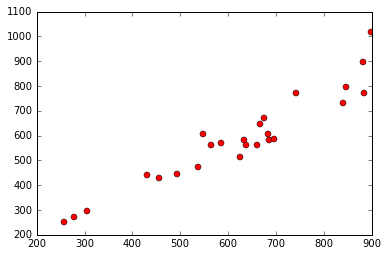

In [166]:
hits = get_hits(coc.peaks,mols,[protonated])
true = []
measured = []
for mol in hits:
    true.append(mol.rt)
    measured.append(hits[mol].rt)
plt.plot(true,measured,'ro')
print hits

Have a look at the cluster sizes

In [167]:
mol_sizes = []
for mol in hits:
    mol_sizes.append((mol.name,coc.Z[hits[mol]].size))

mol_sizes = sorted(mol_sizes,key=lambda x: x[1],reverse=True)
print mol_sizes

[('Phenylhydrazine', 26), ('Serotonin', 24), ('4-Aminobenzoate', 20), ('N-Acetyl-D-glucosamine', 20), ('Glycerol', 18), ('Selenomethionine', 15), ('L-Leucine', 10), ('Melatonin', 10), ('riboflavin', 7), ('Adenine', 7), ('L-Tryptophan', 7), ('Nicotinate', 6), ('L-Proline', 5), ('L-Glutamine', 5), ('Pyridoxine', 4), ('sn-glycero-3-Phosphocholine', 3), ('Imidazole-4-acetate', 2), ('L-Phenylalanine', 1), ('L-Methionine', 1), ('L-Threonine', 1), ('Creatinine', 1), ('D-Glucosamine', 1), ('L-Asparagine', 1), ('Cytidine', 1), ('Inosine', 1)]


Look at an individual cluster and see what we can find

Cluster has 7 members
376.138284396 377.145214423 10309306.0


(346.13828439635995, 406.13828439635995)

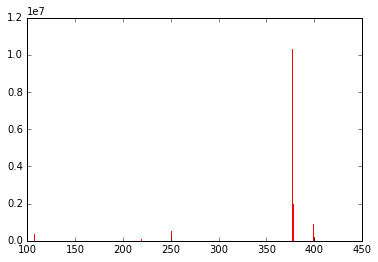

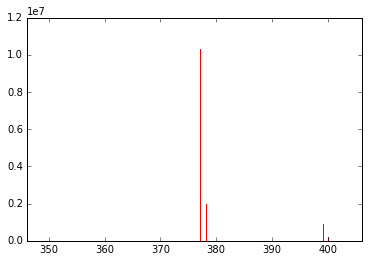

In [174]:
mi = [m for m in mols if m.name=='riboflavin'][0]
mip = hits[mi]
cluster = coc.Z[mip]
print "Cluster has {} members".format(len(cluster.members))
plot_peaks(cluster.members,log=False)
plot_peaks(cluster.members,log=False)
print mi.mass,mip.mass,mip.intensity
plt.xlim([mi.mass-30,mi.mass+30])

Perform the voting...

In [196]:
from voter import Voter,PeakGroup
v = Voter(transformations)
groups = []
for cluster in coc.clusters:
    groups += v.make_groups(cluster.members)

In [218]:
baseline_M = []
for p in coc.peaks:
    baseline_M.append((protonated.transform(p),1))
our_M = []
for g in groups:
    our_M.append((g.M,g.vote))
print len(baseline_M),len(our_M)

def get_M_hits(M_list,mols):
    hits = []
    for m in M_list:
        for mol in mols:
            if hit(mol.mass,m[0],0,0,mtol=10,rttol=1):
                if not mol in [h[0] for h in hits]:
                    hits.append((mol,m[1]))
                
    return hits
base = get_M_hits(baseline_M,mols)
our = get_M_hits(our_M,mols)
print np.array([o[1] for o in our]).mean()
print np.array([g.vote for g in groups]).mean()

6150 5375
2.68431818182
1.09715906977


In [193]:
def get_group_hits(group,mols):
    # Currently ignores RT
    avgM = 0.0
    for p in group.members:
        avgM += p[2]
    avgM /= len(group.members)
    hits = []
    for mol in mols:
        if hit(avgM,mol.mass,0,0,mtol=10,rttol=1):
            hits.append(mol)
    return hits

print mi.mass
for i,g in enumerate(groups):
    print "Group {}".format(i)
    total_vote = 0.0
    pe = []
    for m in g.members:
        pe.append(m[0])
        print m[2],m[1],m[0],'%.2E' % m[0].intensity,m[1].vote
    print g.vote,g.M,[h for h in get_group_hits(g,mols)]

376.138284396
Group 0
376.138304899 M+H[C13] (378.148936188, 446.924346924) 1.98E+06 0.9
376.138279889 M+Na[C13] (400.130855806, 445.691436768) 1.83E+05 0.54
376.137965442 M+Na (399.127186522, 445.691436768) 8.79E+05 0.6
376.137937971 M+H (377.145214423, 446.924346924) 1.03E+07 1.0
3.04 376.137998938 [riboflavin (376.138284396,492.6)]
Group 1
249.043497159 M+H (250.050773611, 449.391967773) 5.39E+05 1.0
1.0 249.043497159 []
Group 2
217.99302134 M+H (219.000297792, 446.924346924) 1.13E+05 1.0
1.0 217.99302134 []
Group 3
106.041862713 M+H (107.049139165, 445.691436768) 3.75E+05 1.0
1.0 106.041862713 []


In [151]:
for m in mols:
    print (m.name,m.mass,m.rt)

('Glycine', 75.03202841014, 923.4000000000001)
('Putrescine', 88.10004839616, 1176.6)
('beta-Alanine', 89.04767847442, 901.1999999999999)
('Glycerol', 92.04734412342, 538.2)
('L-Serine', 105.04259309652, 931.1999999999999)
('Phenylhydrazine', 108.0687482676, 306.0)
('Creatinine', 113.0589118628, 563.4000000000001)
('L-Proline', 115.06332853869999, 742.8000000000001)
('Selenomethionine', 117.07897860297999, 660.6)
('L-Valine', 117.07897860297999, 725.4)
('L-2_4-Diaminobutanoate', 118.07422757608, 1187.3999999999999)
('L-Threonine', 119.0582431608, 846.5999999999999)
('Nicotinate', 123.03202841013999, 430.79999999999995)
('Taurine', 125.01466378651999, 886.1999999999999)
('Imidazole-4-acetate', 126.04292744752, 675.6)
('trans-4-Hydroxy-L-proline', 131.0582431608, 849.0)
('L-Leucine', 131.09462866726, 625.8)
('L-Asparagine', 132.0534921339, 898.8000000000001)
('L-Aspartate', 133.03750771862, 891.0)
('Adenine', 135.0544951869, 548.4000000000001)
('4-Aminobenzoate', 137.04767847442, 634.2)


Some redundant cells - probably to be chopped

In [195]:
a = [1,2,3]
b = [4,5,6]
print a+b

[1, 2, 3, 4, 5, 6]
